<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'> Previsão de Vazões de Rios</h1>
</div>


Esse trabalho tem como objetivo demonstrar o processo de projeção através de modelos de séries temporais. Para isso, utilizaremos os dados de vazões de um rio, fornecidos pelo Operador Nacional de Sistemas Elétrico (ONS), medidos mensalmente entre 1984 e 2004. Tais dado serão submetidos ao modelo ARIMA, que estará apto a projetar vazões do rio em estudo.

O processo inicia pela a análise dos dados para verificar se estes estão dentro das característcas de estacionaridade e aderência à distribuição normal. No próximo passo é aplicada as técnicas de transformação para ajustar os dados a fim de alcançar as referidas características. Na sequência é feito a modelagem, onde chegou-se a conclusão que o modelo ARIMA apresentou o melhor resultado, para a projeção das vazões. Finalizando com a previsão de 4 meses em 2005.

### Conteúdo:
1. Importação das bibliotecas


2. Análise de dados
  - Carga dos dados
  - Análise da Estrutura
  - Análise Exploratória
  - Verificação da Estacionaridade
  - Aderência a Distribuição Normal
  - Decomposição da Série
  - Conclusão


3. Transformação da Série
  - Suavização
  - Aderência a Distribuição Normal
  - Verificação da Estacionaridade
  - Conclusão


4. Modelagem
  - Análise da Autocorrelação
  - Treinamento
  - Análise dos Resíduos
  - Análise do Ajuste
  - Conclusão


5. Previsão
  - Previsão para quatro meses
  - Conclusão

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Importação das bibliotecas</h2>
</div>

In [468]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import scipy.stats as stats

from statsmodels.tsa.arima.model import ARIMA

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Análise de dados</h2>
</div>

Nesta seção:
  - Carga dos dados
  - Análise da estrutura
  - Análise Exploratória
  - Verificação da Estacionaridade
  - Aderência a Distribuição Normal.
  - Decomposição da Série

### 2.1. Carga de Dados

Será carregado 20 anos mensais sobre vazões.

In [469]:
date_parser = lambda dates: datetime.strptime(dates, '%d/%m/%Y')

data = pd.read_csv('Vazoes_Mensais.csv', 
                   sep=";", header=0, index_col=0, date_parser=date_parser)

### 2.2. Análise da Estrutura

A estrutura de dados de uma série temporal univariada no pandas, deve ter como índice o tempo e um campo de valor, neste caso um índice com uma data mensal e uma valor para a vazão.

In [470]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1984-01-01 to 2004-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Vazao   252 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


### 2.3. Análise Exploratória

Nesta seção será verificado:

  - Quantidade de Dados.
  - Existência de dados nulos e como completa-los.
  - Existência de vazões com valor zero que pode influênciar na seção de transformação dos dados.
  - Medição de valores discrepantes (Outliers).
  

In [471]:
print(f'Quantidade de valores: {len(data)}')
print(f'Quantidade de dados nulos: {data["Vazao"].isnull().sum()}')
print(f'Quantidade de valores zerados: {len(data.loc[data["Vazao"] == 0].value_counts())}')

Quantidade de valores: 252
Quantidade de dados nulos: 0
Quantidade de valores zerados: 0


In [472]:
# Medição dos outliers

In [473]:
data.head()

,Vazao
Data,
1984-01-01,2192
1984-02-01,1315
1984-03-01,994
1984-04-01,914
1984-05-01,861


### 2.4. Verificação da Estacionariedade

Nesta seção será plotado os dados da vazão ao longo dos meses para visualente verificar se a série pode ser estacionária.

Para confirmar a análise visual, será aplicado o teste de Dickey-Fuller para confirmar a estacionaridade da série temporal.

In [474]:
# Função de aplicação do teste de Dickey-Fuller que retorna um valor binnário se série é estacionária.

def isStationary(values, print_results=False):
    dfuller = adfuller(values, autolag='AIC')
    result = pd.Series(dfuller[0:4], index=['Teste', 'Valor-p', '# Lags', '# Obs'])
    for key, value in dfuller[4].items():
        result[f'Valores Críticos({key})'] = value
    if print_results:
        print(result)
    is_tationary = True if result['Valor-p'] < 0.5 else False
    return is_tationary

Text(0, 0.5, 'Vazao')

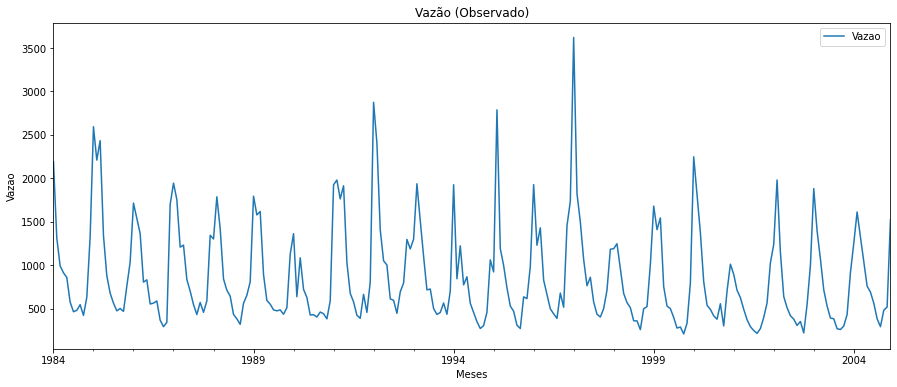

In [475]:
data.plot()
plt.title('Vazão (Observado)')
plt.xlabel('Meses')
plt.ylabel('Vazao')

In [476]:
if isStationary(data.Vazao.values):
    print('Série é estacionária')
else:
    print('Série não é estacionária')

Série é estacionária


### 2.5. Aderência a Distribuição Normal.

Nesta seção será plotado o histograma e o quantile-quantile para verificar visualmente se há aproximação da distribuição normal. Para confirmar a aderência será aplicado o teste Shapiro-Wilk.

#### Plotagem do histograma

<AxesSubplot:ylabel='Count'>

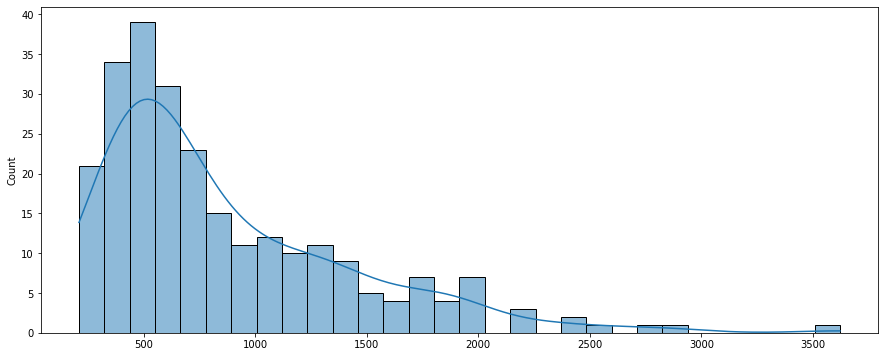

In [477]:
sns.histplot(data=data.Vazao.values, kde=True, bins=30)

#### Plotagem do quantile-quantile

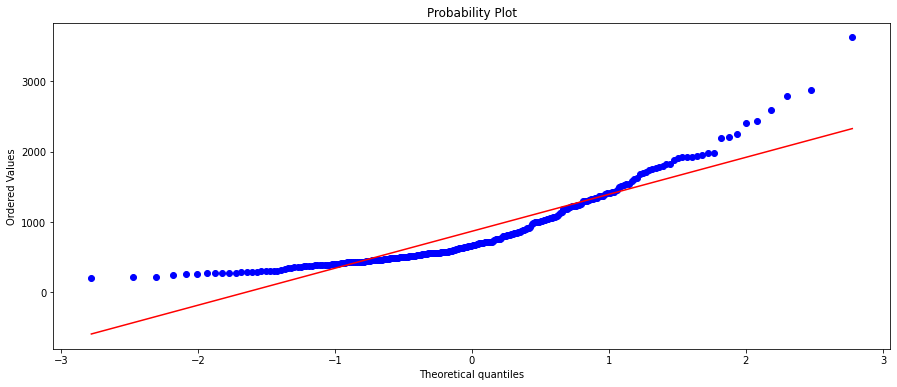

In [478]:
stats.probplot(data.Vazao.values, dist="norm", plot=plt)
plt.show()

#### Teste Shapiro-Wilk para aderência a distribuição normal.

In [479]:
shapiro_test = shapiro(data.Vazao.values)
print('Teste de normalidade')
print(f'Statisct Test: {shapiro_test.statistic}')
adhesion = 'aderente distribuição normal' if shapiro_test.pvalue > 0.05 else 'não aderente distribuição normal' 
print(f'p-value: {round(shapiro_test.pvalue, 5)} - Série Original {adhesion}')

Teste de normalidade
Statisct Test: 0.8536005616188049
p-value: 0.0 - Série Original não aderente distribuição normal


### 2.6. Decomposição da Série.

Nesta seção será visto através da decomposição da série se há tendência ou sazonalidade.

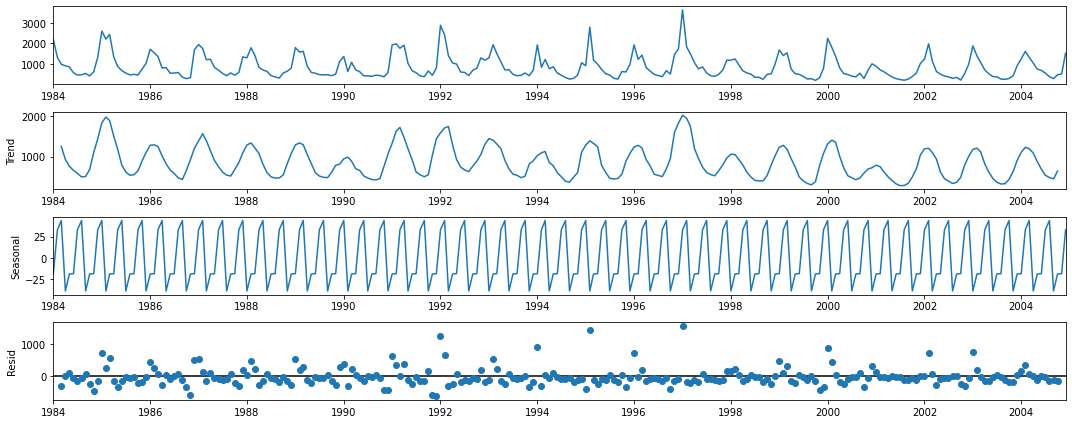

In [480]:
decompose = seasonal_decompose(data,  model='additive', period=5)
decompose.plot()
plt.show()

### 2.7. Conclusão

Apesar da série temporal apresentar escacionariadade, esta não é aderente a distribuição normal, apresentando uma leve tendência e uma acentuada sazonalidade.

Portanto, será necessário a transformação da série para alcançar as caracterisitcas supracitadas que não estão adequadas para o processo de modelagem.


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Transformação da Série</h2>
</div>

Nesta Seção:
  - Suavização da Série
  - Aderência a Distribuição Normal
  - Aplicação Teste de Estacionariada
  - Análise da Autocorrelação
  
Para cada procedimento, será verificado se a série original não é aderente a distribuição normal, indicando a necessidade da aplicação listada acima.

### 3.1. Suavização da Série

Transfomando a série para aproximar a distribuição normal, remover sazonalidade e a tendência.

In [481]:
series = data.copy()

if shapiro_test.pvalue <= 0.05:
    # Transforma série para obter a aderência a distribuição normal.
    series['Vazao'] = np.log(series['Vazao'])
    # Copia a série transformada para fazer a diferenciação
    seriesd = series.copy()
    # Remove a sazonalidade a cada 12 meses.
    seriesd['Vazao'] = seriesd['Vazao'].diff(periods=12) 
    seriesd.dropna(axis=0, inplace=True)
    # Remoção da tendência.
    seriesd['Vazao'] = seriesd['Vazao'].diff(periods=1)
    seriesd.dropna(axis=0, inplace=True)

#### Plotando a série suavizado.

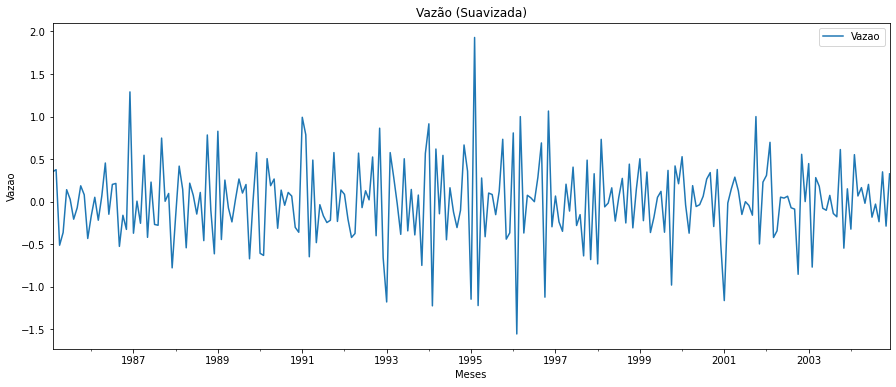

In [482]:
if shapiro_test.pvalue <= 0.05:
    seriesd.plot()
    plt.title('Vazão (Suavizada)')
    plt.xlabel('Meses')
    plt.ylabel('Vazao')


### 3.2. Aderência a Distribuição Normal

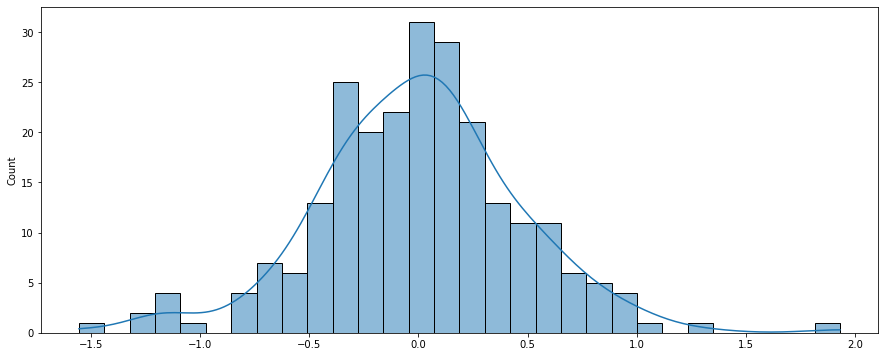

In [483]:
if shapiro_test.pvalue <= 0.05:
    sns.histplot(data=seriesd.Vazao.values, kde=True, bins=30)


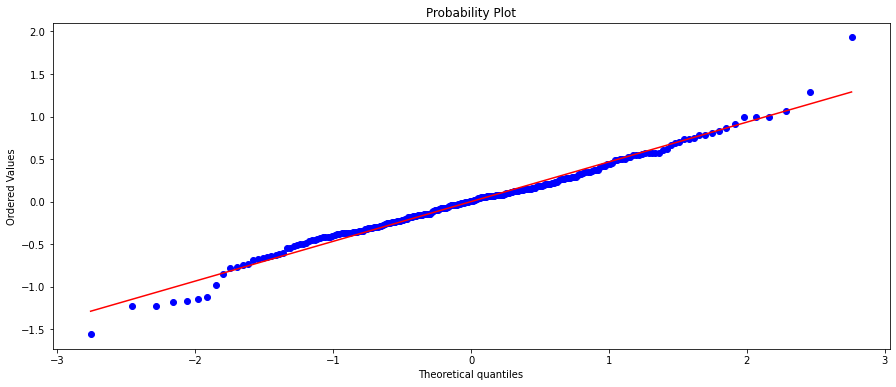

In [484]:
if shapiro_test.pvalue <= 0.05:
    stats.probplot(seriesd.Vazao.values, dist="norm", plot=plt)
    plt.show()

#### Teste de Shapiro-Wilk para verfifica a aderência a distribuição normal sobre a série suavizada.


In [485]:
if shapiro_test.pvalue <= 0.05:
    shapiro_test = shapiro(seriesd.Vazao.values)
    print('Teste de normalidade')
    print(f'Statisct Test: {shapiro_test.statistic}')
    adhesion = 'aderente distribuição normal' if shapiro_test.pvalue > 0.05 else 'não aderente distribuição normal' 
    print(f'p-value: {round(shapiro_test.pvalue, 5)} - Série Suavizada {adhesion}.')

Teste de normalidade
Statisct Test: 0.9838048219680786
p-value: 0.00799 - Série Suavizada não aderente distribuição normal.


### 3.3. Verificação da Estacionaridade

#### Teste de estacionaridade sobre a série suavizada.

In [486]:
if shapiro_test.pvalue <= 0.05:
    if isStationary(seriesd.Vazao.values):
        print('Série transformada é estacionária')
    else:
        print('Série transformada não é estacionária')       


Série transformada é estacionária


### 3.4. Conclusão

Apesar do teste Shapiro-Wilk não confirmar a aderência à distribuição normal, o gráfico quantile-quantile exibe que está próxima dessa distribuição de probabilidade. Com isso, pode-se dar continuidade a modelagem da série temporal.

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Modelagem</h2>
</div>

Nesta Seção:
  - Análise da Autocorrelação
  - Treinamento
  - Análise dos Resíduos
  - Análise do Ajuste


### 4.1. Análise da Autocorrelação



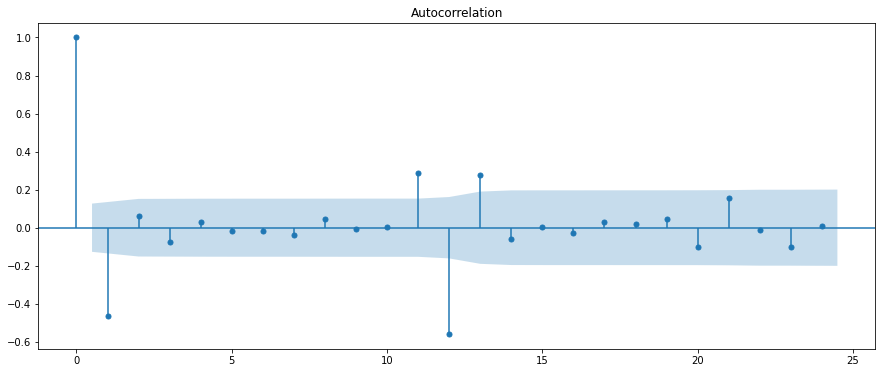

In [487]:
plot_acf(seriesd.Vazao.values)
plt.show()

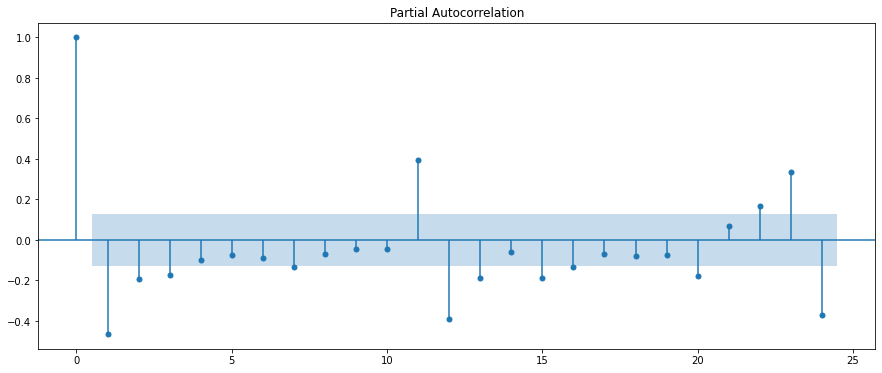

In [488]:
plot_pacf(seriesd.Vazao.values)
plt.show()

### 4.2. Treinamento

In [489]:
# Quebra os dados da série em treinamento e teste.
treshold = int(len(series) * 0.90)
train = series[:treshold]
test = series[treshold:]

In [490]:
# Aplica o modelo Arima para AutoRegressão e Média Móvel.
model = ARIMA(train, order=(3,1,1), seasonal_order=(1,1,1,12))

model_fit = model.fit()
print(model_fit.summary())


c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                    SARIMAX Results                                     
Dep. Variable:                            Vazao   No. Observations:                  226
Model:             ARIMA(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -32.949
Date:                          Mon, 16 Aug 2021   AIC                             79.898
Time:                                  11:31:22   BIC                            103.427
Sample:                              01-01-1984   HQIC                            89.407
                                   - 10-01-2002                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3295      0.078      4.209      0.000       0.176       0.483
ar.L2          0.1221      0.072      1.704      0.

### 4.3. Análise dos Resíduos

c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


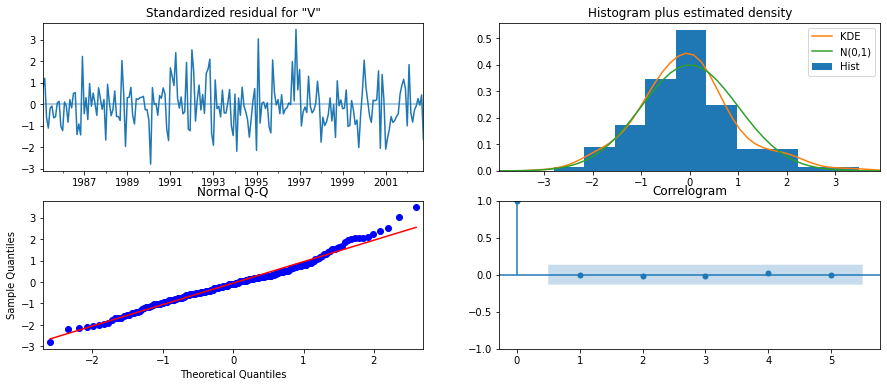

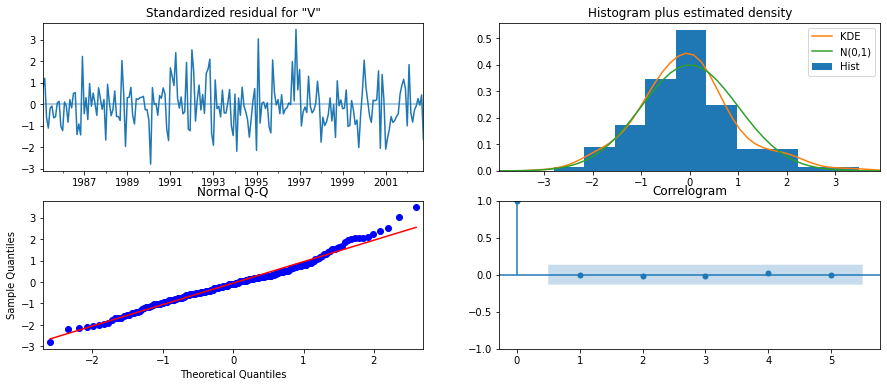

In [499]:
model_fit.plot_diagnostics(lags=5)


### 4.4 Análise do Ajuste

Text(0, 0.5, 'Vazão')

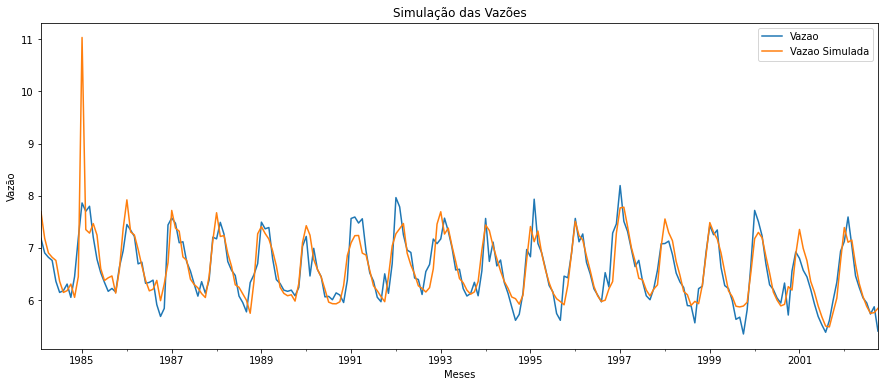

In [492]:
residual = pd.DataFrame(model_fit.resid, columns=['Vazao_Residual'])

series_adjusted = pd.concat([train, residual], axis=1)
series_adjusted.dropna(axis=0, inplace=True)
series_adjusted['Vazao Simulada'] = series_adjusted['Vazao'] - series_adjusted['Vazao_Residual']

series_adjusted.drop(columns=['Vazao_Residual'], inplace=True)

date = datetime.strptime('1984-01-01', '%Y-%m-%d')
series_adjusted = series_adjusted.drop(index=date)


series_adjusted.plot()
plt.title('Simulação das Vazões')
plt.xlabel('Meses')
plt.ylabel('Vazão')


### 4.5. Conclusão

As plotagens das funções de autocorrelação e autocorrelação parcial indicam para um model de média móvel de ordem 1. Então, foi definido a ordem ARIMA(train, order=(0,1,1), seasonal_order=(1,1,1,12)) com AIC igual a 84.485.

Experimentando uma variação dos parâmetros, chegou-se ao modelo ARIMA(train, order=(3,1,1), seasonal_order=(1,1,1,12)) que apresentou o AIC igual a 79.898

Ambos apresentam resídulos aderente a distribuição normal com respectivo FAC não apresentando auto-correlação, assim como na análise visual na Simulação dos Vazões, a diferença não foi significante.

Analisando o Mean Square Error mínimo e máximo dos dois modelos sobre a projeção (Seção 5), pode-se observar que o modelo 2 apresenta medidas mais adequadas. Portanto o modelo 2 foi selecionado.

Modelo 1 MSE: Mínimo = 0.2731; Máximo = 0.5318; AIC = 84.485

Modelo 2 MSE: Mínimo = 0.2635; Máximo = 0.3323; AIC = 79.898

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Previsão</h2>
</div>

### 5.1.  Previsão para quatro meses

Esta seção passará por duas etapas, sendo a primeira averificação do intervalo de confiança a partir do série suavizada a fim de verificar a robustez. Na segunda etapa os dados transformados serão revertidos para os dados reais demonstrando a previsão para quatro meses em 2005.

In [493]:
result = model_fit.get_forecast(steps=len(test)+4)
summ = pd.DataFrame(result.summary_frame(alpha=0.05))

In [494]:
forecast_data = pd.concat([series, summ], axis=1)

se_mim = round(forecast_data['mean_se'].min(), 4)
se_max = round(forecast_data['mean_se'].max(), 4)
forecast_data.drop(columns=['mean_se'], inplace=True)

dict = {}
for name in forecast_data.columns: 
    dict[name] = name
dict['mean'] = 'Vazao Projetada'
dict['mean_ci_lower'] = 'Intervalo Inferior'
dict['mean_ci_upper'] = 'Intervalo Superior'
dict
forecast_data.columns = [value for key, value in dict.items()]

print(f'MSE: Mínimo = {se_mim} e Máximo = {se_max}')


MSE: Mínimo = 0.2635 e Máximo = 0.3323


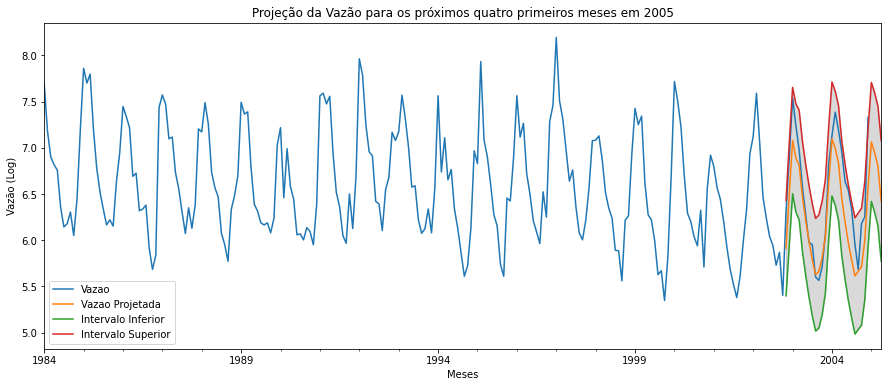

In [495]:
forecast_data.plot()
plt.title('Projeção da Vazão para os próximos quatro primeiros meses em 2005')
plt.xlabel('Meses')
plt.ylabel('Vazão (Log)')

plt.fill_between(forecast_data.index, 
                 forecast_data['Intervalo Inferior'], 
                 forecast_data['Intervalo Superior'], 
                 color='k', alpha=.15)

In [496]:
forecast_data['Vazao'] = round(np.exp(forecast_data['Vazao']), 1)
forecast_data['Vazao Projetada'] = round(np.exp(forecast_data['Vazao Projetada']), 1)
forecast_data['Intervalo Inferior'] = round(np.exp(forecast_data['Intervalo Inferior']), 1)
forecast_data['Intervalo Superior'] = round(np.exp(forecast_data['Intervalo Superior']), 1)

threshold = datetime.strptime('2002-01-01', '%Y-%m-%d')

forecast_data = forecast_data.loc[forecast_data.index >= threshold]

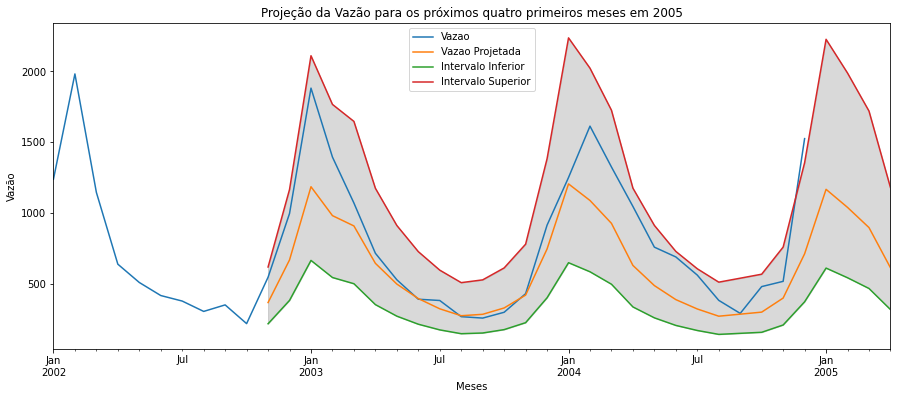

In [497]:
forecast_data.plot()
plt.title('Projeção da Vazão para os próximos quatro primeiros meses em 2005')
plt.xlabel('Meses')
plt.ylabel('Vazão')

plt.fill_between(forecast_data.index, 
                 forecast_data['Intervalo Inferior'], 
                 forecast_data['Intervalo Superior'], 
                 color='k', alpha=.15)

### 5.3. Conclusão
O modelo projeta de vazões com robustez em função valores de teste e valores futuros estarem dentro do intervalo de confiança, assim como acompanha o padrão dos dados observados.